# Censored regression example

Supporting material for a talk at at PyData Global 2024

Benjamin T. Vincent

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from pymc_marketing.mmm.transformers import logistic_saturation


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
%config InlineBackend.figure_format = "retina"
seed: int = sum(map(ord, "ladder"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

/Users/benjamv/miniforge3/envs/pydata_global_2024_causal_ladder/lib/python3.12/site-packages/pytensor/tensor/random/op.py:83: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/benjamv/miniforge3/envs/pydata_global_2024_causal_ladder/lib/python3.12/site-packages/pytensor/tensor/random/op.py:93: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


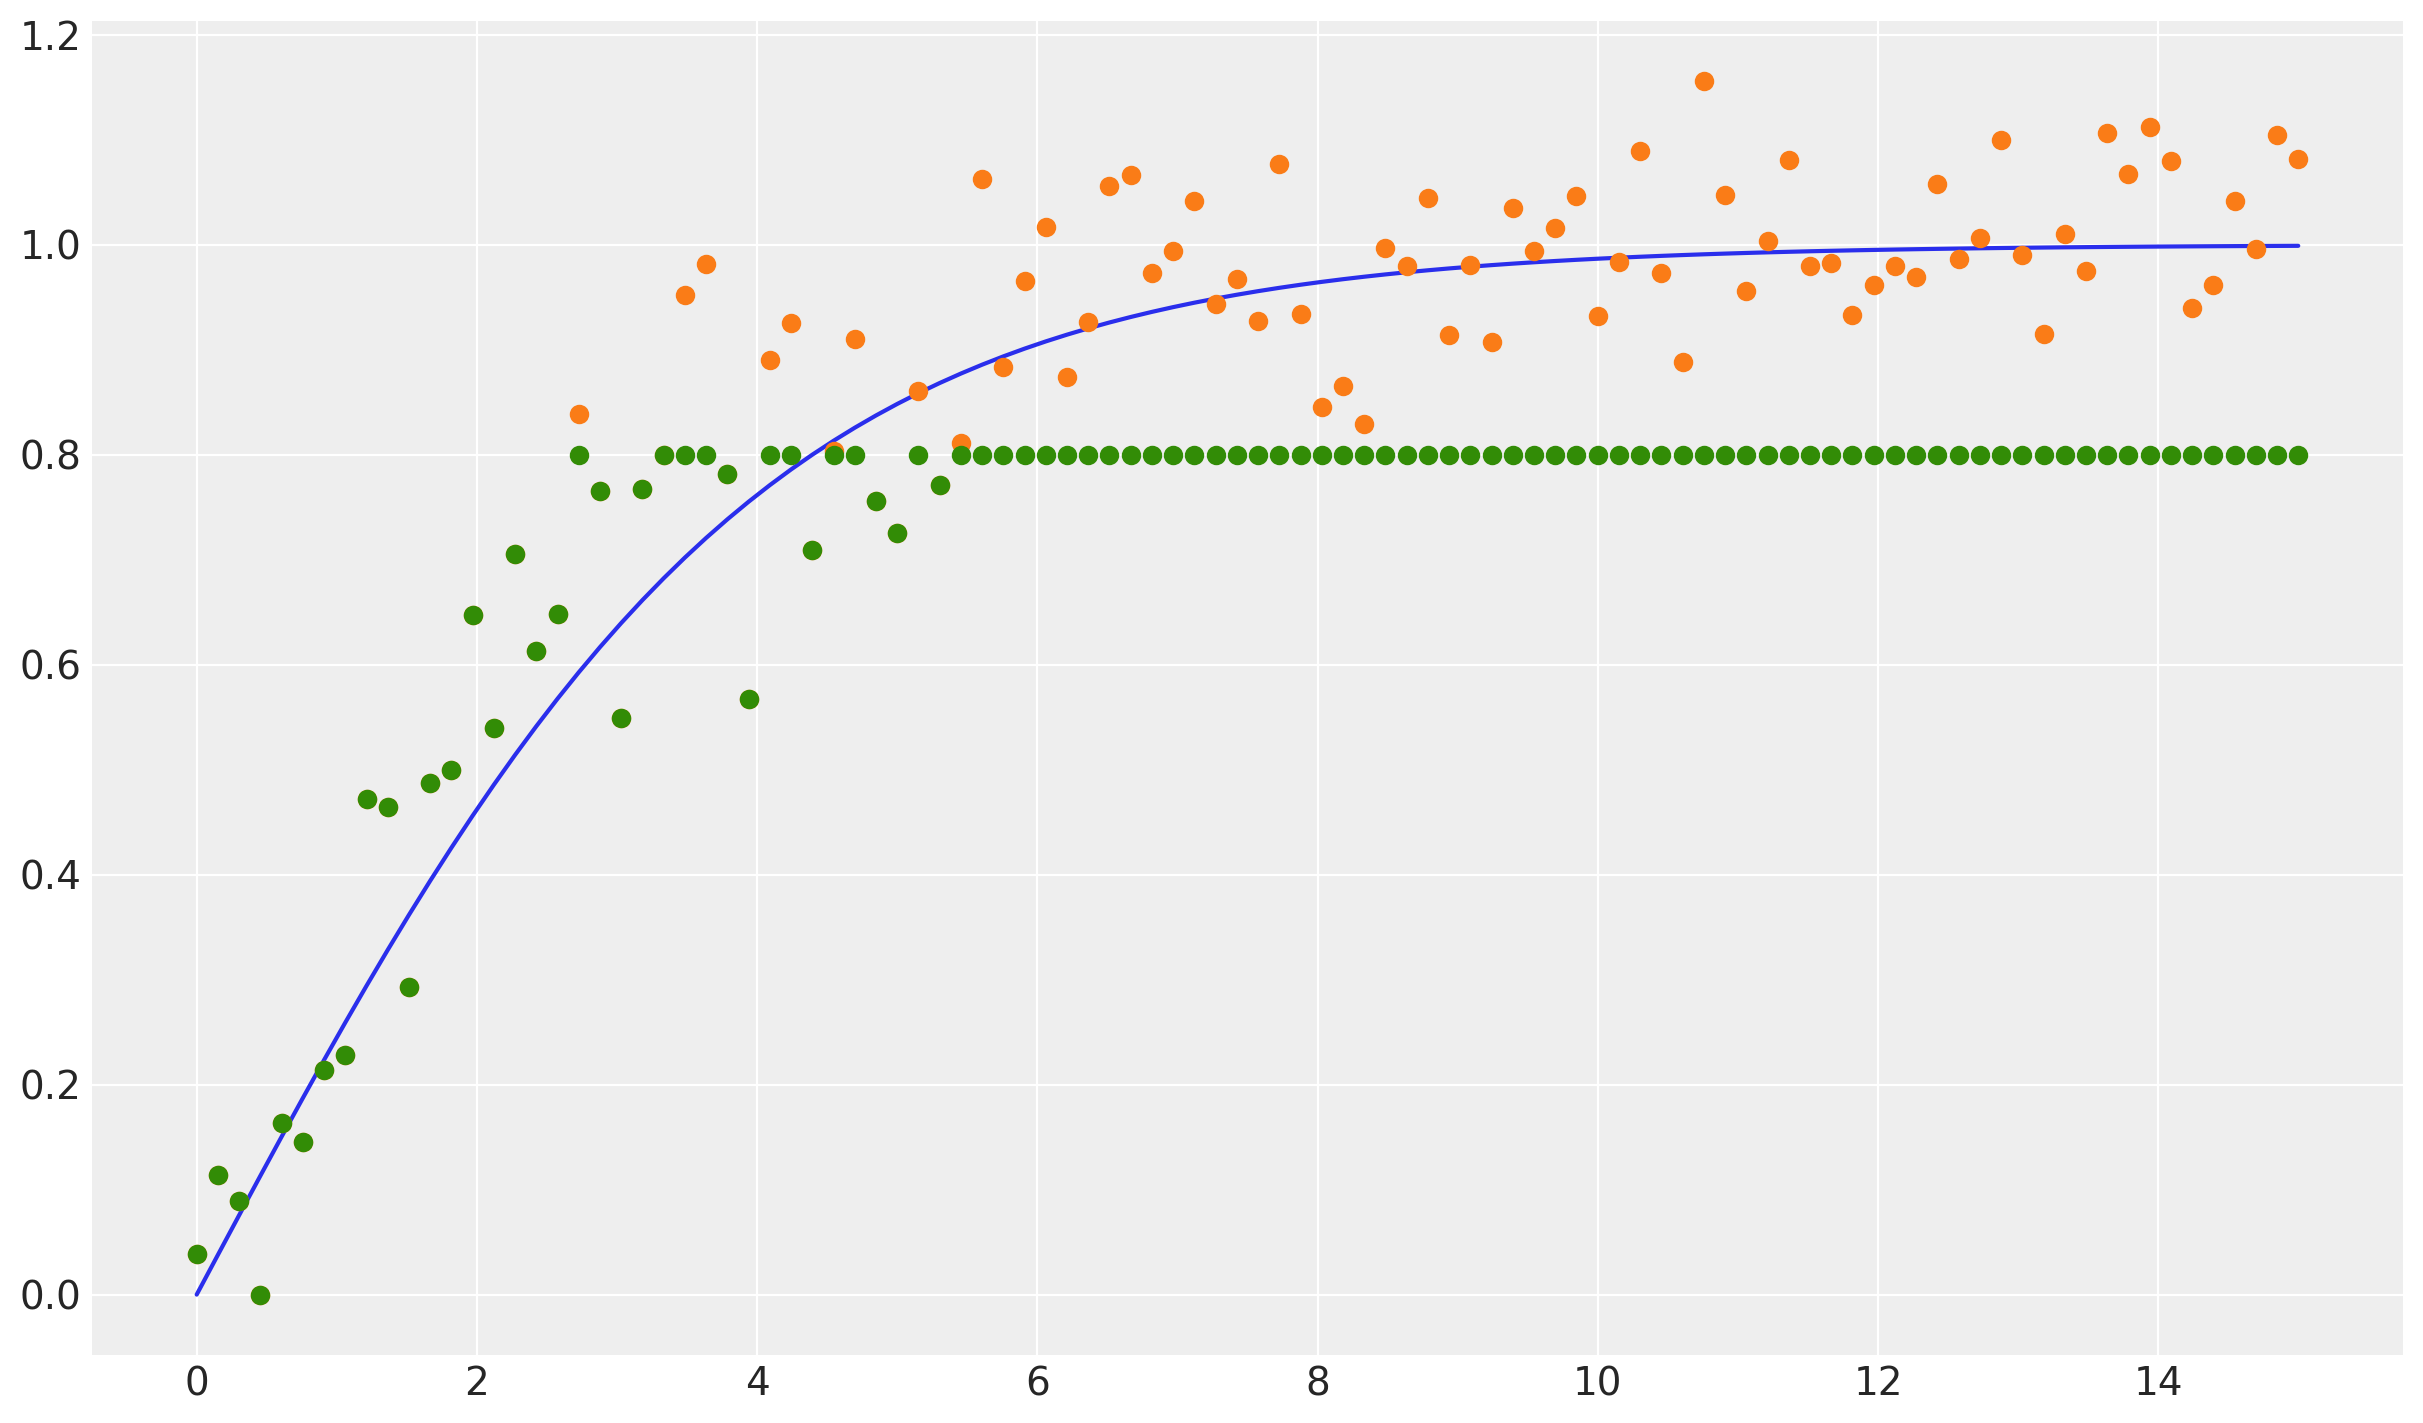

In [2]:
N = 100
slope = 0.1
x = np.linspace(0, 15, N)
mu = logistic_saturation(x, 0.5).eval()
y = np.clip(mu + rng.normal(0, 0.1, size=N), 0, np.inf)
upper = 0.80
sales = y.copy()
sales[y > upper] = upper

plt.plot(x, mu, "-")
plt.plot(x, y, "o")
plt.plot(x, sales, "o")

In [3]:
# sales ~ media
with pm.Model() as regression_model:
    asymptote = pm.Normal("asymptote", 1, 1)
    lam = pm.Gamma("lam", 1, 1)
    sigma = pm.Gamma("sigma", alpha=1, beta=1)
    _mu = pm.Deterministic("mu", asymptote * logistic_saturation(x, lam))

    censored_normal = pm.Normal("sales", mu=_mu, sigma=sigma, observed=sales)

    idata_regression = pm.sample()
    idata_regression.extend(pm.sample_posterior_predictive(idata_regression))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [asymptote, lam, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [sales]


Output()

In [4]:
with pm.Model() as censored_model:
    asymptote = pm.Normal("asymptote", 1, 1)
    lam = pm.Gamma("lam", 1, 1)
    sigma = pm.Gamma("sigma", alpha=1, beta=1)
    _mu = pm.Deterministic("mu", asymptote * logistic_saturation(x, lam))

    normal_dist = pm.Normal.dist(mu=_mu, sigma=sigma)
    censored_normal = pm.Censored(
        "sales", normal_dist, upper=np.ones(N) * upper, observed=sales
    )

    idata_censored = pm.sample()
    idata_censored.extend(pm.sample_posterior_predictive(idata_censored))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [asymptote, lam, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [sales]


Output()

[Text(0.5, 0, 'Media spend [$]'),
 Text(0.5, 1.0, 'Censored regression much better!'),
 [Text(-2.5, 0, ''),
  Text(0.0, 0, ''),
  Text(2.5, 0, ''),
  Text(5.0, 0, ''),
  Text(7.5, 0, ''),
  Text(10.0, 0, ''),
  Text(12.5, 0, ''),
  Text(15.0, 0, ''),
  Text(17.5, 0, '')],
 []]

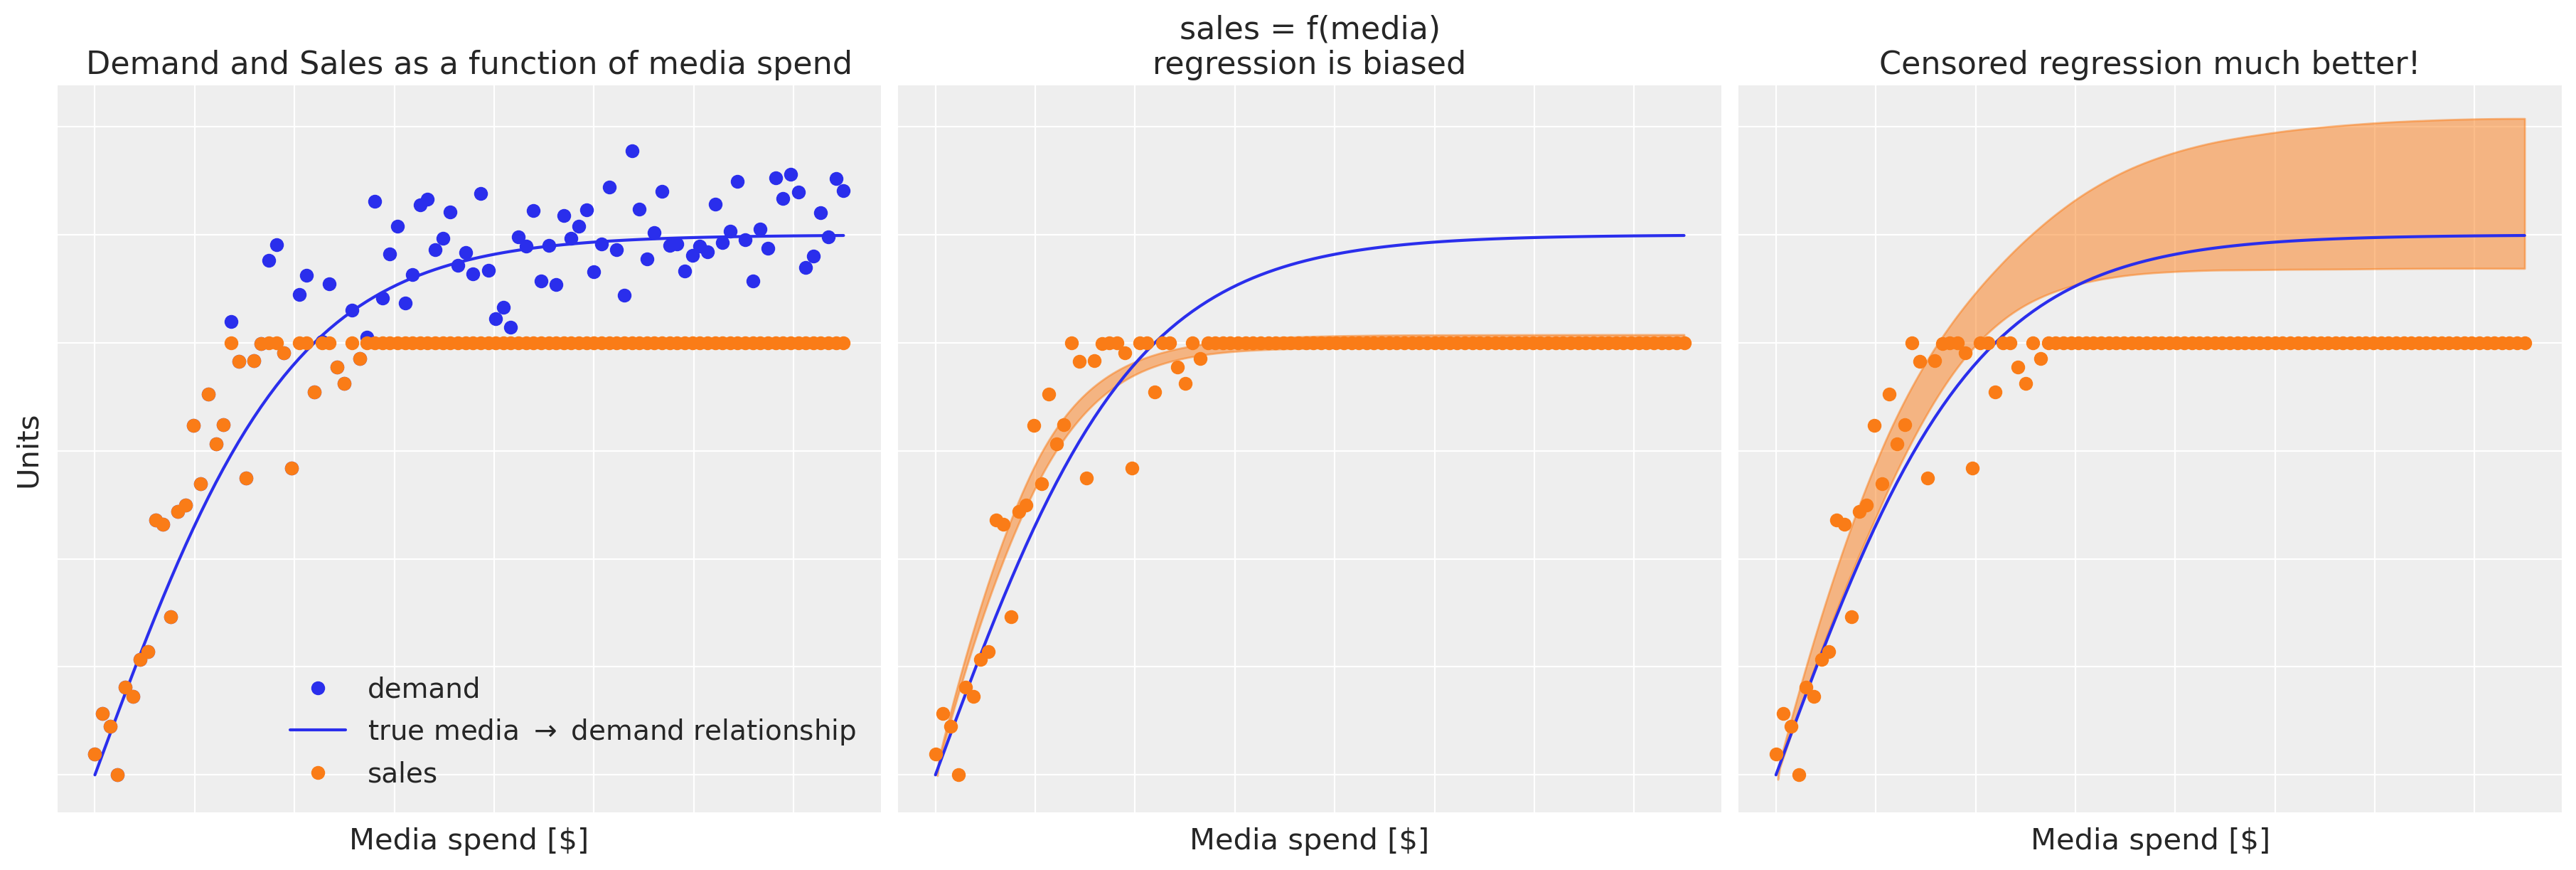

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

ax[0].plot(x, y, "o", color="C0", label="demand")
ax[0].plot(
    x, mu, "-", color="C0", label=r"true media $\rightarrow$ demand relationship"
)
ax[0].plot(x, sales, "o", color="C1", label="sales")
ax[0].legend()
ax[0].set(
    xlabel="Media spend [$]",
    ylabel="Units",
    title="Demand and Sales as a function of media spend",
    xticklabels=[],
    yticklabels=[],
)

# REGRESSION: SALES ~ MEDIA ------------------------------------------------------------
az.plot_hdi(x, idata_regression.posterior.mu, ax=ax[1])
# ax[1].plot(x, y, "o", color="C0", label="demand")
ax[1].plot(
    x,
    mu,
    "-",
    color="C0",  # label=r"true media $\rightarrow$ demand relationship"
)
ax[1].plot(x, sales, "o", color="C1", label="sales")
# ax[1].legend()
ax[1].set(
    xlabel="Media spend [$]",
    # ylabel="Units",
    title="sales = f(media)\nregression is biased",
    xticklabels=[],
    yticklabels=[],
)

# CENSORED REGRESSION: SALES ~ MEDIA ---------------------------------------------------

az.plot_hdi(x, idata_censored.posterior.mu, ax=ax[2])
# ax[2].plot(x, y, "o", color="C0", label="demand")
ax[2].plot(
    x,
    mu,
    "-",
    color="C0",  # label=r"true media $\rightarrow$ demand relationship"
)
ax[2].plot(x, sales, "o", color="C1", label="sales")
# ax[2].legend()
ax[2].set(
    xlabel="Media spend [$]",
    # ylabel="Units",
    title="Censored regression much better!",
    xticklabels=[],
    yticklabels=[],
)
# plt.savefig(
#     "img/censored_regression_story.png", bbox_inches="tight", dpi=300, facecolor="white"
# )